In [7]:
using PyPlot
using JuMP, Ipopt

In [8]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

## Initialize model

In [11]:
dt = 1.
t = Array(2020:dt:2100);
model = ClimateModel(
    "soldatenko",
    t,
    dt,
    present_year,
    Economics(t),
    Physics(),
    init_zero_controls(t)
);

## Model optimization

We now calculate the optimal trajectories of climate control deployments $\alpha$ by minimizing an objective function (also known as a "cost function") under a set of physical and policy constraints. The physical constraints are that the fractional deployments of climate controls are between 0 (no deployment) and 1 (full deployment). The policy constraints are that the climate controls begin at 0 fraction deployment in 2020 and that deployments can only change at a maximum rate of $\partial \alpha \, / \, \partial t < 1/30$ (i.e. from zero to full deployment in 30 years).

The model currently supports three optimizations options, representing different assumed cost functions or additional policy constraints:
- `temp` (default): in this scenario, the model finds the lowest total discounted cost of climate controls which results in temperatures that remain below a specified temperature goal. The temperature goal is given as an additional parameter in degrees Celsius, e.g. `optimize_controls!(model, maxslope = maxslope, obj_option = "temp", temp_goal = 2.0)`.

- `net_cost`: in this scenario, the model optimizes the total net discounted cost of handling climate change, including both the direct costs $\beta \, \delta T_{\alpha}^{2} \, (1 - \chi)$ of (controlled) damages from climate impacts and the costs $\sum C_{\alpha}f(\alpha)$ of deploying climate controls.

- `budget`: in this scenario, the model finds the combination of discounted climate control investments which, given a specified budget, provides the lowest (controlled) damages from cimate impacts. The budget is given as an additional parameter in trillions of USD, e.g. `optimize_controls!(model, maxslope = maxslope, obj_option = "budget", budget = 10.)`.

In [12]:
maxslope = 1. /30.
optimize_controls!(
    model,
    maxslope = maxslope,
    obj_option = "temp",
    temp_goal = δT_init+1.0,
    temp_final = δT_init,
    max_deployment=Dict("remove"=>0., "mitigate"=>0., "geoeng"=>1., "adapt"=>0.)
);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      883
Number of nonzeros in inequality constraint Jacobian.:      283
Number of nonzeros in Lagrangian Hessian.............:      928

Total number of variables............................:      523
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      361
                     variables with only upper bounds:        0
Total number of equ

### Plotting the optimal solution state

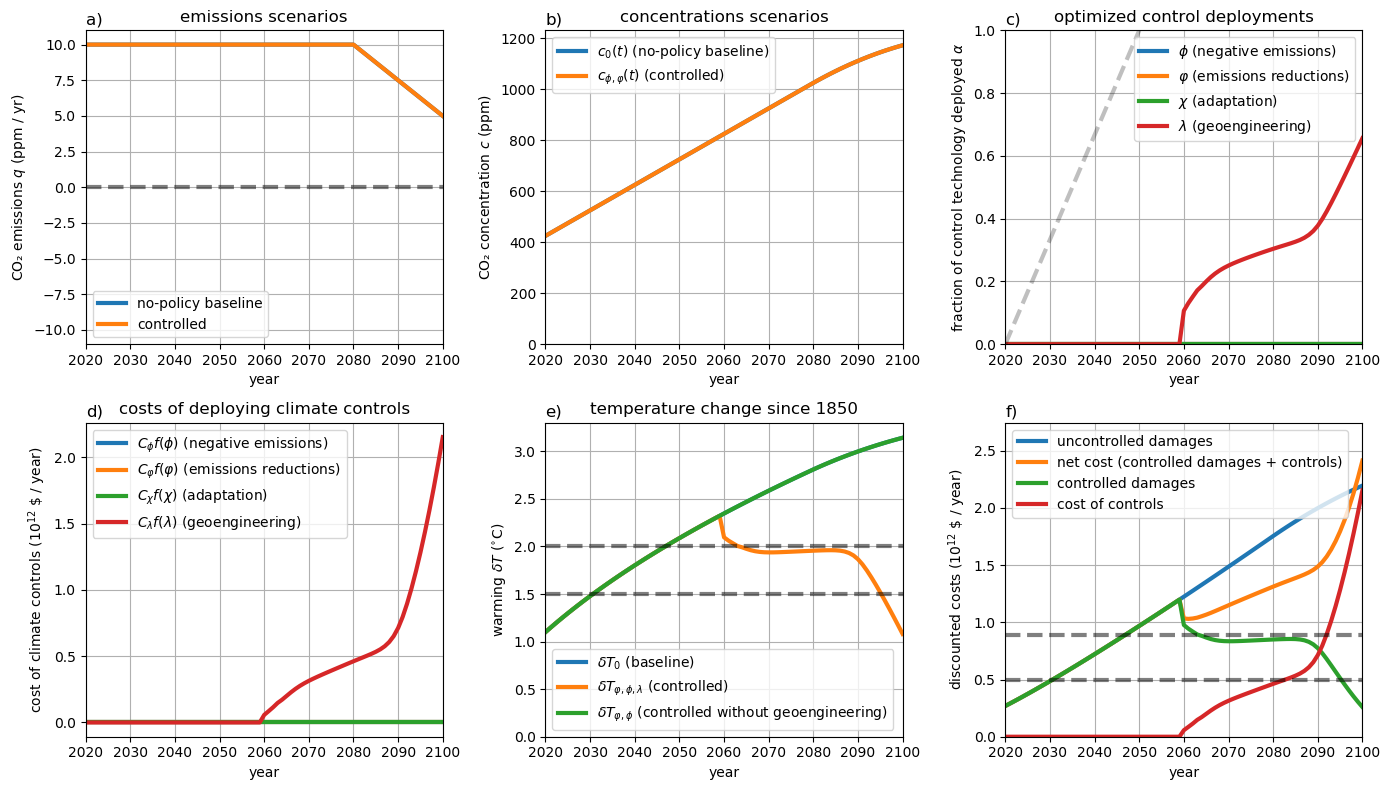

In [13]:
plot_state(model)

# Individual panels of the figure can be modified using PyPlot commands
# (see https://github.com/JuliaPy/PyPlot.jl)
subplot(2,3,3)
plot([2020., 2020. + 1. /maxslope], [0.,1.], "k--", alpha=0.25) # add a slope showing the faster possible ramp up of controls

savefig("../figures/replicate_soldatenko.png", bbox_inches="tight", dpi=100)